### Packages

In [2]:
# cd /project/3022057.01/IFA
# module load anaconda3
# source activate IFAenv
# jupyter notebook --no-browser --ip=* --port=8888 --NotebookApp.token=''

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import sawtooth
from sklearn.decomposition import FastICA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import MDS
from sklearn.covariance import LedoitWolf
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso, Lasso, LassoCV, ElasticNet, MultiTaskLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from nilearn import plotting as nplot
from nilearn import image as nimg
from nilearn import datasets, plotting
from nilearn.regions import connected_label_regions
from nilearn import input_data
from nilearn import image as nimg
from nilearn.connectome import ConnectivityMeasure
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann, unupper
from pyriemann.utils.distance import distance_riemann
from pyriemann.utils.base import logm
import torch

### Load Atlas & Create Mask

Number of Labels in Mask:  208


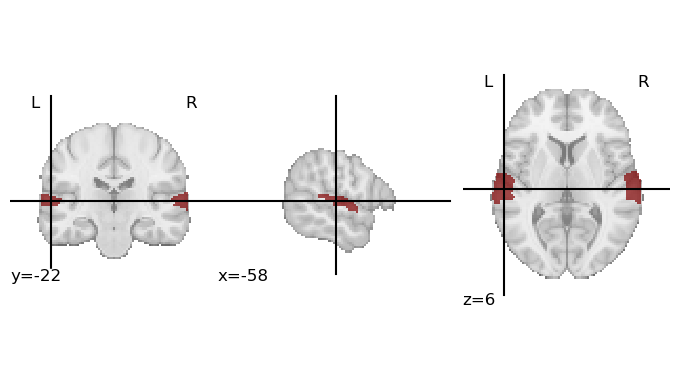

In [3]:
# Parcellation and Atlas References:
    # https://dartbrains.org/content/Parcellations.html#summary-of-differences-between-parcellations
    # https://nipy.org/nibabel/nibabel_images.html
    # https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
    # https://nilearn.github.io/dev/modules/generated/nilearn.regions.Parcellations.html
    # https://dartbrains.org/content/Parcellations.html#nilearn
    # https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html

def create_mask(dir='../resources/rois/', n_rois=200, yeo_networks=17, resolution_mm=1):
    """
    Create a brain mask using the Schaefer atlas or a provided directory.
    
    Parameters:
    dir (str): Directory to fetch or load atlas data from.
    n_rois (int): Number of regions of interest.
    yeo_networks (int): Number of Yeo networks.
    resolution_mm (int): Resolution in millimeters.

    Returns:
    tuple: NiftiLabelsMasker object, atlas image, and region labels.
    """
    if dir == '../resources/rois/':
        parcel_dir = dir
        schaefer = datasets.fetch_atlas_schaefer_2018(n_rois, yeo_networks, resolution_mm, data_dir=parcel_dir)
        atlas_schaefer = schaefer['maps']
        atlas = connected_label_regions(atlas_schaefer)
    else:
        atlas = dir

    masker = input_data.NiftiLabelsMasker(labels_img=atlas, standardize=True)
    atlas_img = nimg.load_img(atlas)
    region_labels = np.unique(atlas_img.get_fdata())
    region_labels = np.setdiff1d(region_labels, [0])  # Remove the background label (0)

    return masker, atlas, region_labels

def view_labels(atlas, roi='a == 1'):
    """
    View the labels of the atlas for a specified region of interest (ROI).
    
    Parameters:
    atlas (Nifti1Image): Atlas image.
    roi (str): Mathematical expression to specify the ROI.

    """
    roi_mask = nimg.math_img(roi, a=atlas)
    nplot.plot_roi(roi_mask, cmap='jet')

fine_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
# course_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_coarse_79parcels.nii.gz"  # Uncomment this, comment above, and change below for course ICP
mask, atlas, region_labels = create_mask(fine_ICP)
print("Number of Labels in Mask: ", len(region_labels))
view_labels(atlas)

### Load and Parcellate Subjects (REVIST INCOMPLETE)

In [ ]:
def load(n=0, folder1=0, folder2=-1):
    """
    Load data for a specified number of subjects and fMRI tasks.

    Parameters:
    n (int): Number of subjects to load (default is 0).
    folder1 (int): Index of the first fMRI task folder (default is 0).
    folder2 (int): Index of the second fMRI task folder, if any (default is -1).

    Returns:
    list: A list of tuples containing paths to the subject data files.
    """
    # Min and max number of subjects
    if n < 0:
        n = 0
    elif n > 1113:
        n = 1113

    # Define the directory where the data is stored
    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    # Define the list of folders for rfMRI and tfMRI
    folders = [
        "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
        "tfMRI_EMOTION_LR", "tfMRI_EMOTION_RL", "tfMRI_GAMBLING_LR", "tfMRI_GAMBLING_RL",
        "tfMRI_LANGUAGE_LR", "tfMRI_LANGUAGE_RL", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL",
        "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL",
        "tfMRI_WM_LR", "tfMRI_WM_RL"
    ]
    
    # Randomly select n subjects without repetition
    selected_subjects = set()
    subjects = os.listdir(base_directory)
    while len(selected_subjects) < n:
        subject = random.choice(subjects)
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + ".nii.gz")

        # Check if the file exists before adding the subject
        if os.path.exists(subject_data1):
            if folder2 >= 0:
                subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder2], folders[folder2] + ".nii.gz")
                # Check if the second file exists before adding it
                if os.path.exists(subject_data2):
                    selected_subjects.add((subject_data1, subject_data2))
            else:
                selected_subjects.add((subject_data1,))

    return [list(sub) for sub in selected_subjects]

def parcellate(sub_data, masker, region_labels, verbose=False):
    """
    Parcellate fMRI data into regions of interest.

    Parameters:
    sub_data (Nifti1Image): The fMRI data to be parcellated.
    masker: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    verbose (bool): If True, print additional information (default is False).

    Returns:
    np.ndarray: The parcellated fMRI data.
    """
    # Create parcellated data
    parcellated = masker.fit_transform(sub_data)
    num_labels = len(region_labels)
    
    # Number of timepoints
    num_timepoints = sub_data.shape[3]
    # Create an array of zeros that has the correct size
    final_signal = np.zeros((num_timepoints, num_labels))

    # Get regions that are kept
    regions_kept = np.array(masker.labels_, dtype='int')

    # Fill columns matching labels with signal values
    final_signal[:, regions_kept-1] = parcellated
    if verbose:
        print("Number of atlas labels: ", num_labels)
        print("Number of parcellated labels: ", len(masker.labels_))
        print("Missing labels: ", set(region_labels) - set(np.unique(masker.labels_)))
    return final_signal

def parcellate_all(allsubs, mask, region_labels, save=False, verbose=False, location=''):
    """
    Parcellate data for all subjects and tasks, and optionally save the results.

    Parameters:
    allsubs (list): List of subject data paths.
    mask: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    save (bool): If True, save the parcellated data (default is False).
    verbose (bool): If True, print additional information (default is False).
    location (str): The directory location to save the parcellated data (default is '').

    Returns:
    list: List of parcellated data arrays for all subjects and tasks.
    """
    main_output_directory = os.path.normpath(r"/project/3022057.01/")

    alldata = []
    for sub in allsubs:
        for task in sub:
            if verbose:
                print(task)
            sub_data = nimg.load_img(task)
            parcellated = parcellate(sub_data, mask, region_labels, verbose=verbose)
            alldata.append(parcellated)
            if save:
                subdir = task[task.find("S1200") + len("S1200"):].split("/")[1]
                taskdir = task[task.find("Results") + len("Results"):].split("/")[1]
                sub_output_directory = os.path.join(main_output_directory, location, subdir)
                os.makedirs(sub_output_directory, exist_ok=True)
                output_filename = os.path.join(sub_output_directory, f"{taskdir}_parcellated.npy")
                if verbose:
                    print(output_filename)
                np.save(output_filename, parcellated)
    return alldata

n = 200
folder1 = 8
folder2 = 16

allsubs = load(n, folder1, folder2)
print(allsubs)
alldata = parcellate_all(allsubs, mask, region_labels, save=True, verbose=True, location="icp_parcellated_subs")

### Load and or Simulate Data (REVIST INCOMPLETE)

TODO Time Series Checks and Paths Hardcoded

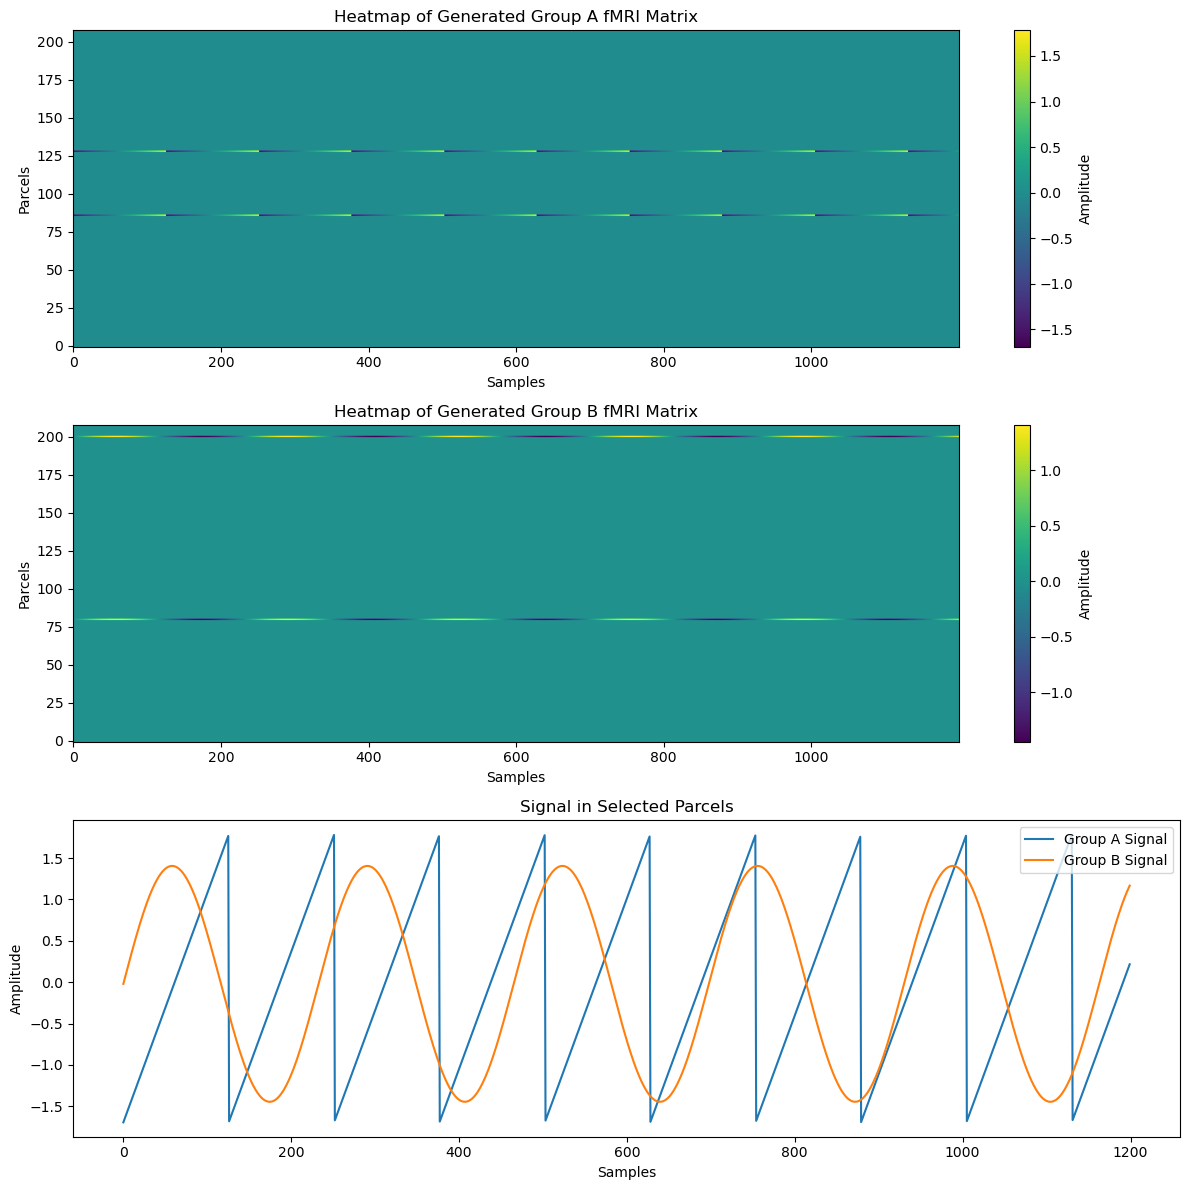

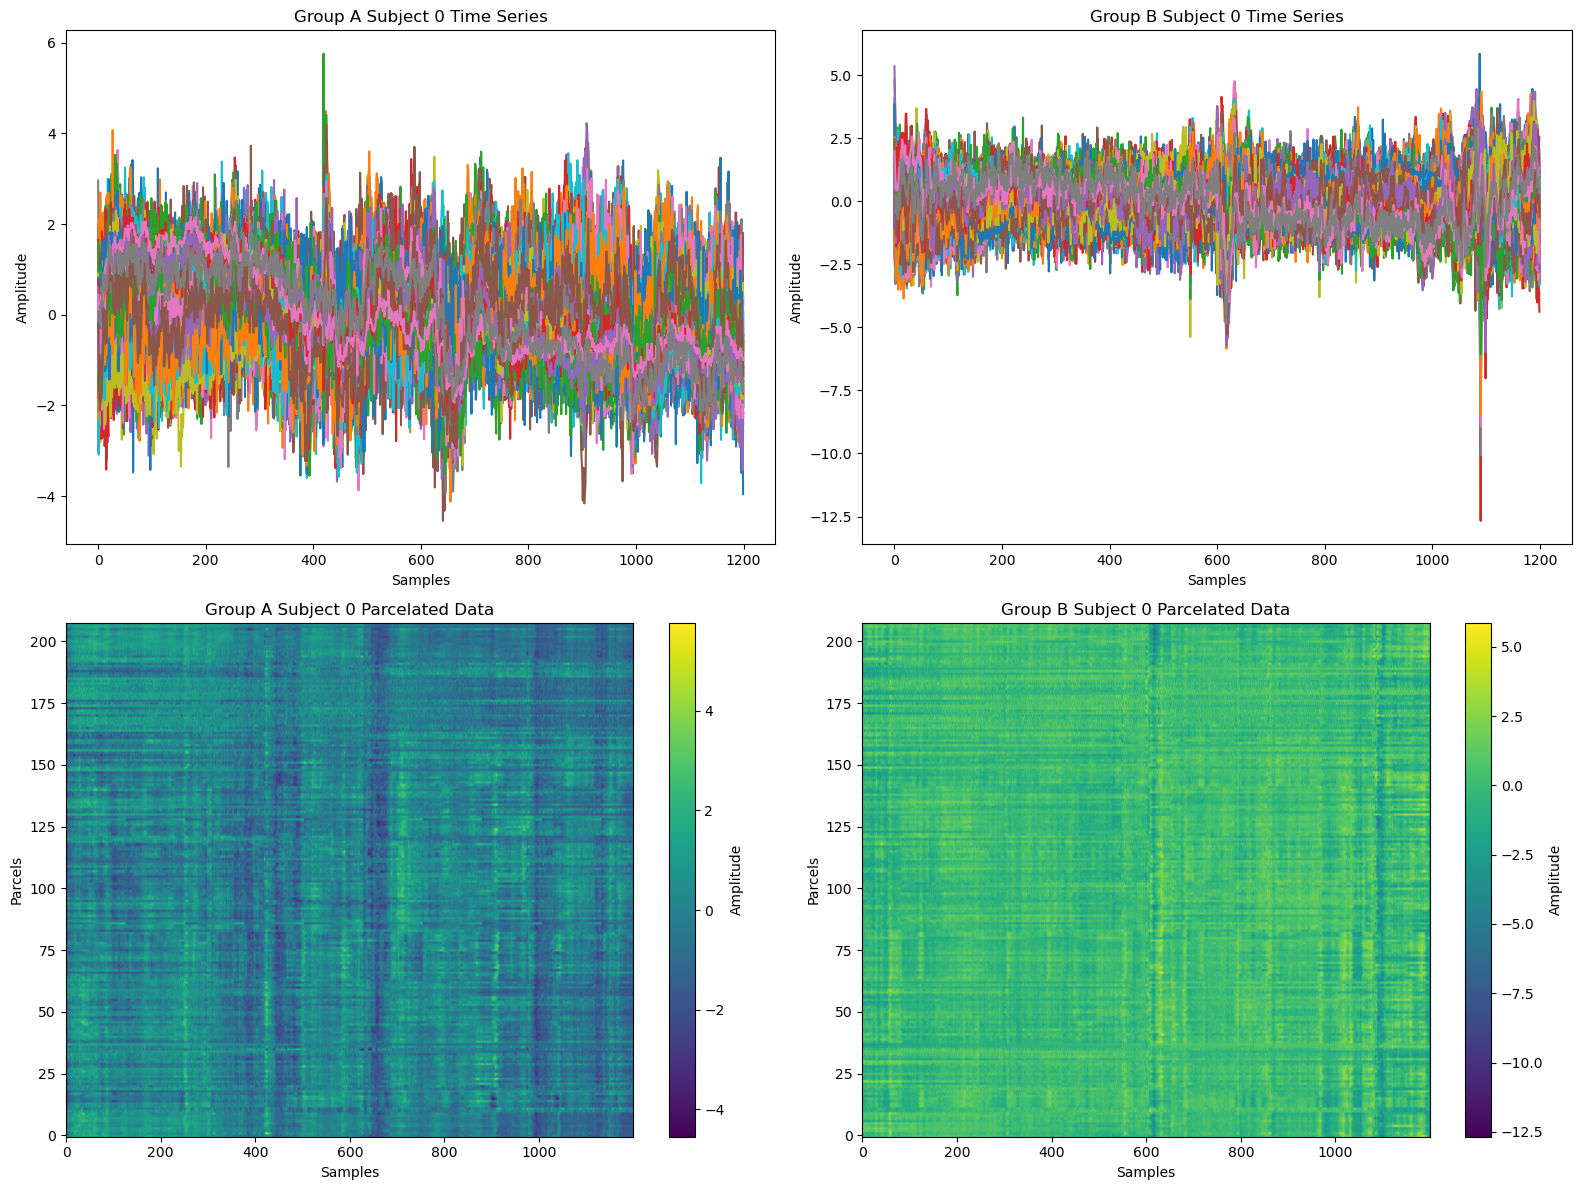

In [11]:
def create_signal(samples, parcels, sig_freqA=0.03, sig_freqB=0.05, spatial_ratio=0.1, signal_type="saw", visualize=False):
    """
    Create and add signal to a random subset of parcels.

    Parameters:
    samples (int): Number of samples.
    parcels (int): Number of parcels.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    signal_type (str): Type of the signal, 'saw' or 'sin'.
    visualize (bool): Whether to visualize the signals and heatmaps.

    Returns:
    tuple: groupA_signal, groupB_signal, groupA_parcels, groupB_parcels
    """
    
    num_parcels_with_signal = int(spatial_ratio * parcels)
    groupA_parcels = np.random.choice(parcels, size=num_parcels_with_signal, replace=False)
    groupB_parcels = np.random.choice(np.setdiff1d(np.arange(parcels), groupA_parcels), size=num_parcels_with_signal, replace=False)

    x = np.linspace(0, samples, num=samples)
    if signal_type == "sin":
        groupA_signal = np.sin(sig_freqA * x)
        groupB_signal = sawtooth(sig_freqB * x)
    else:
        groupA_signal = sawtooth(sig_freqA * x)
        groupB_signal = np.sin(sig_freqB * x)

    groupA_signal = (groupA_signal - np.mean(groupA_signal)) / np.std(groupA_signal)
    groupB_signal = (groupB_signal - np.mean(groupB_signal)) / np.std(groupB_signal)

    parcelsA = np.zeros((samples, parcels))
    parcelsB = np.zeros((samples, parcels))

    parcelsA[:, groupA_parcels] += np.reshape(groupA_signal, (-1, 1))
    parcelsB[:, groupB_parcels] += np.reshape(groupB_signal, (-1, 1))

    if visualize:
        plt.figure(figsize=(12, 12))
        plt.subplot(3, 1, 1)
        plt.imshow(parcelsA.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group A fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')
        
        plt.subplot(3, 1, 2)
        plt.imshow(parcelsB.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group B fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')

        plt.subplot(3, 1, 3)
        plt.plot(groupA_signal, label="Group A Signal")
        plt.plot(groupB_signal, label="Group B Signal")
        plt.title('Signal in Selected Parcels')
        plt.legend()
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    return groupA_signal, groupB_signal, groupA_parcels, groupB_parcels

def simulate_data(allsubs_data, sig_freqA=0.03, sig_freqB=0.5, spatial_ratio=0.01, sub_ratio=0.5, original_level=0.5, simulateA=True, simulateB=True):
    """
    Simulate data by adding signals to a subset of subjects.

    Parameters:
    allsubs_data (numpy.ndarray): Array of all subjects' data.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    sub_ratio (float): Ratio of subjects to add the signal.
    original_level (float): Weight of the original signal.
    simulateA (bool): Whether to simulate data for group A.
    simulateB (bool): Whether to simulate data for group B.

    Returns:
    tuple: groupA_data, groupB_data, groupA_parcels, groupB_parcels
    """
    
    samples = allsubs_data[0].shape[0]
    parcels = allsubs_data[0].shape[1]
    groupA_signal, groupB_signal, groupA_parcels, groupB_parcels = create_signal(samples, parcels, sig_freqA=sig_freqA, sig_freqB=sig_freqB, spatial_ratio=spatial_ratio, signal_type="saw", visualize=True)

    nsubjects = len(allsubs_data)
    nsubjects_semi_simulated = int(nsubjects * sub_ratio)

    selected_subjects = np.random.choice(nsubjects, size=nsubjects_semi_simulated, replace=False)
    unselected_subjects = np.setdiff1d(np.arange(nsubjects), selected_subjects)

    groupA_data = allsubs_data[selected_subjects, :, :].copy()
    groupB_data = allsubs_data[unselected_subjects, :, :].copy()
    
    if simulateA:
        for i, subject in enumerate(groupA_data):
            for parcel in groupA_parcels:
                subjectA_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupA_data[i, :, parcel] = np.sqrt(original_level) * subjectA_signal + np.sqrt(1 - original_level) * groupA_signal

    if simulateB:
        for i, subject in enumerate(groupB_data):
            for parcel in groupB_parcels:
                subjectB_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupB_data[i, :, parcel] = np.sqrt(original_level) * subjectB_signal + np.sqrt(1 - original_level) * groupB_signal

    return groupA_data, groupB_data, groupA_parcels, groupB_parcels

def visualize_semi_simulated_subject(groupA_data, groupB_data):
    """
    Visualize the semi-simulated subjects' data.

    Parameters:
    groupA_data (numpy.ndarray): Simulated data for group A.
    groupB_data (numpy.ndarray): Simulated data for group B.
    """
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    axes[0, 0].plot(groupA_data[0, :, :])
    axes[0, 0].set_title('Group A Subject 0 Time Series')
    axes[0, 0].set_xlabel('Samples')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(groupB_data[0, :, :])
    axes[0, 1].set_title('Group B Subject 0 Time Series')
    axes[0, 1].set_xlabel('Samples')
    axes[0, 1].set_ylabel('Amplitude')

    img = axes[1, 0].imshow(groupA_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 0])
    cbar.set_label('Amplitude')
    axes[1, 0].set_title('Group A Subject 0 Parcelated Data')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Parcels')
    
    img = axes[1, 1].imshow(groupB_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 1])
    cbar.set_label('Amplitude')
    axes[1, 1].set_title('Group B Subject 0 Parcelated Data')
    axes[1, 1].set_xlabel('Samples')
    axes[1, 1].set_ylabel('Parcels')

    plt.tight_layout()
    plt.show()



subjects_path = r'/project/3022057.01/icp_parcellated_subs'
groupA_data = []
groupB_data = []
groupA_type = "REST"
groupB_type = "MOTOR"
simulate = True

if simulate:
    allsubs_data = []
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    allsubs_data.append(sub_data)
    allsubs_data = np.array(allsubs_data)
    groupA_data, groupB_data, groupA_parcels, groupB_parcels = simulate_data(allsubs_data, sig_freqA=.05,sig_freqB=.027, spatial_ratio=.01, sub_ratio=.5, original_level=.1, simulateA=True, simulateB=True)
else:
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    groupA_data.append(sub_data)
            elif (groupB_type in file):
                groupB_data.append(np.load(os.path.join(subdir,file)))

groupA_data = np.array(groupA_data)
groupB_data = np.array(groupB_data)

visualize_semi_simulated_subject(groupA_data, groupB_data)

### Standardize and Demean Subjects (REVIST INCOMPLETE)

TODO Need to decide whether to demean on the subject level, group level, or across spatial dimensions. Will change for application/branch of pipeline

(99, 1200, 208) (99, 1200, 208)


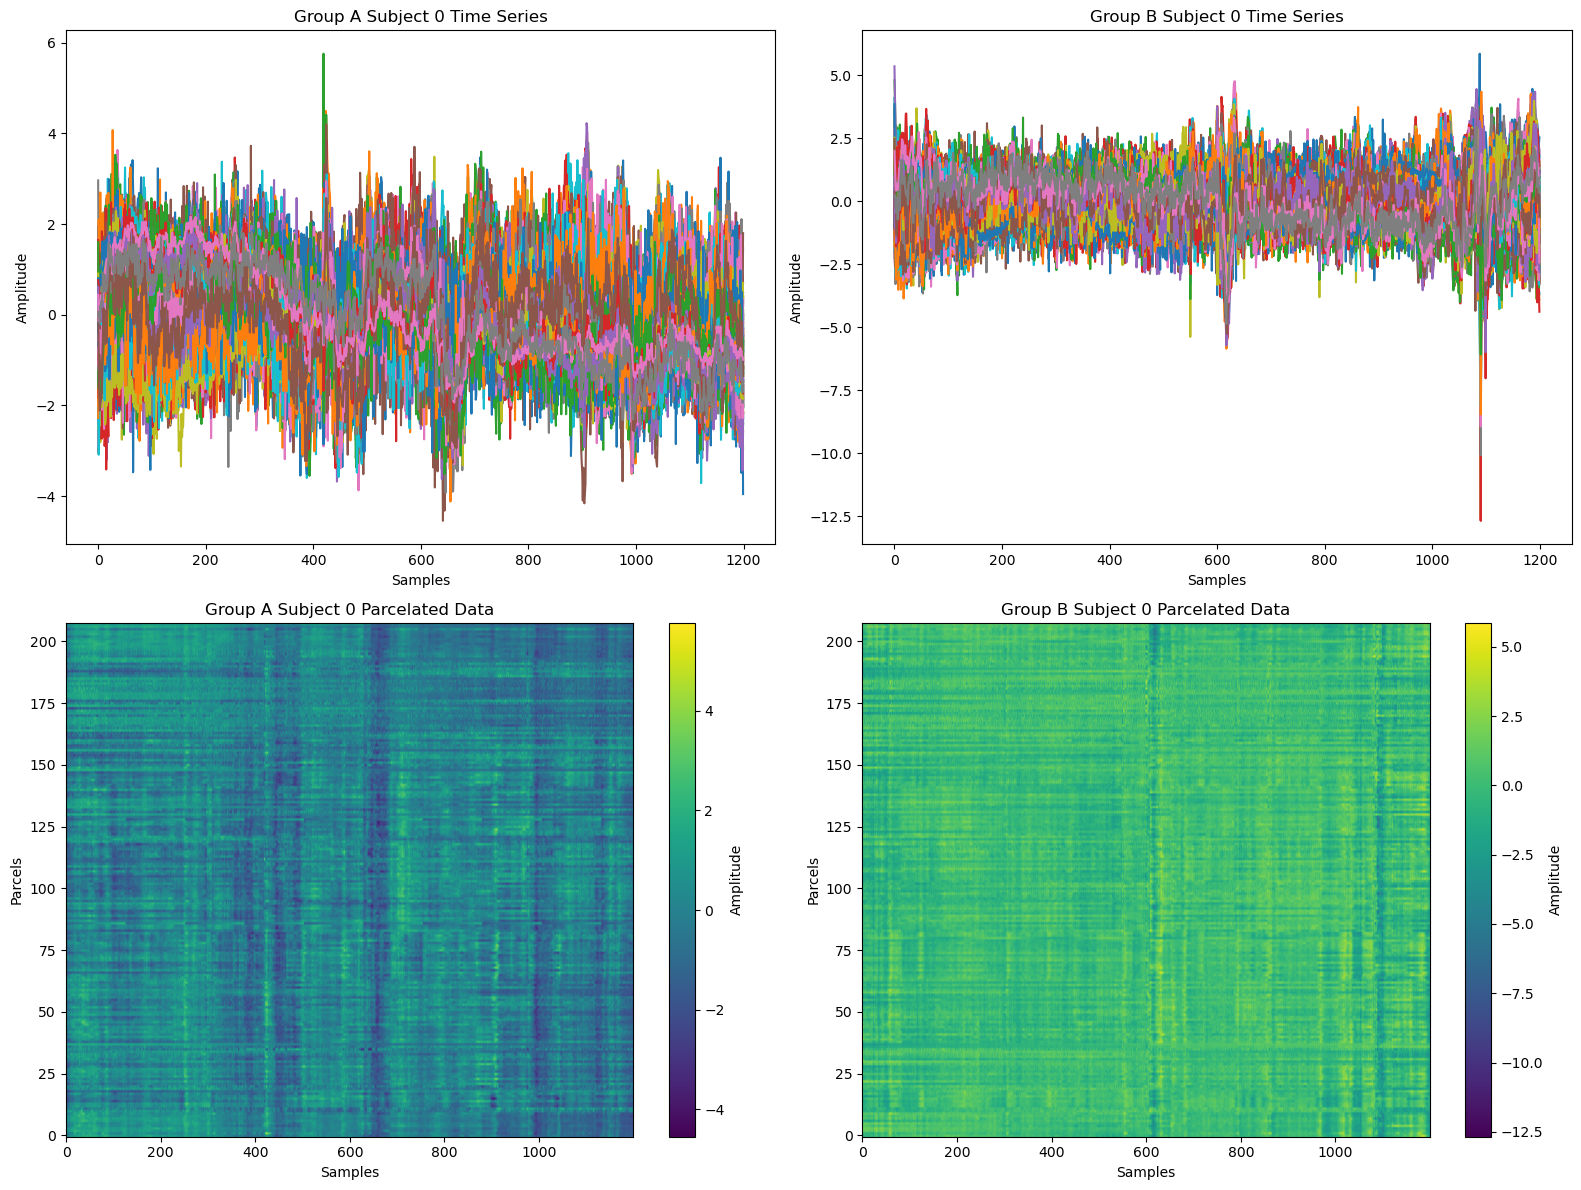

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def standardize_demean_individual(group):
    n_subjects, n_timepoints, n_features = group.shape
    preprocessed_group = np.zeros_like(group)

    for i in range(n_subjects):
        subject = group[i]
        
        # Handle NaNs by imputing with the mean of the column
        imputer = SimpleImputer(strategy='mean')
        subject_imputed = imputer.fit_transform(subject)
        
        # Standardize (demean and scale to unit variance) each subject individually
        scaler = StandardScaler()
        standardized_subject = scaler.fit_transform(subject_imputed)
        
        preprocessed_group[i] = standardized_subject

    return preprocessed_group

# Assuming groupA_data and groupB_data are defined
preprocessed_GroupA = standardize_demean_individual(groupA_data)
preprocessed_GroupB = standardize_demean_individual(groupB_data)
# Assuming visualize_semi_simulated_subject is defined
visualize_semi_simulated_subject(preprocessed_GroupA, preprocessed_GroupB)

### Create Covariance Matrices

In [14]:
# https://pyriemann.readthedocs.io/en/latest/auto_examples/signal/plot_covariance_estimation.html
cov_est = Covariances(estimator='lwf')

# Compute the covariance matrices for preprocessed_GroupA and preprocessed_GroupB
groupA_covs = cov_est.transform(np.transpose(preprocessed_GroupA, (0, 2, 1)))
groupB_covs = cov_est.transform(np.transpose(preprocessed_GroupB, (0, 2, 1)))

### FKT Methods

In [18]:
def FKT(groupA_cov_matrices, groupB_cov_matrices, mean="riemann", average=True, visualize=True, gamma=0.0):
    if average:
        groupA_cov = mean_covariance(groupA_cov_matrices, metric=mean)
        groupB_cov = mean_covariance(groupB_cov_matrices, metric=mean)    
        eigs, filters = eigh(groupA_cov, groupA_cov + groupB_cov + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False)
    else:
        eigs, filters = eigh(groupA_cov_matrices, groupA_cov_matrices + groupB_cov_matrices,eigvals_only=False)
  
    fkt_riem_eigs = np.abs(np.log(eigs/(1-eigs)))**2

    if visualize:
        plt.figure()
        plt.scatter(range(0,fkt_riem_eigs.shape[0]),fkt_riem_eigs)
        plt.title(f'Scree Plot of FKT Filters')
        plt.xlabel('Eig Value Rank')
        plt.ylabel('Eig Value')
        plt.show()
        
    return eigs, filters, fkt_riem_eigs

def tangent_CSP(group1_covs, group2_covs,k=1):    
    all_covs = np.concatenate((group1_covs, group2_covs))
    Frechet_Mean = mean_covariance(all_covs, metric='riemann')
    tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric="riemann")
    tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric="riemann")

    # Initialize the Covariances estimator
    cov_estimator = Covariances(estimator='lwf')
    tangent_projected_mean = np.mean(np.concatenate((tangent_projected_1, tangent_projected_2)),axis=0,keepdims=True)  
    
    tangent_1_mean = np.mean(tangent_projected_1,axis=0,keepdims=True) - tangent_projected_mean
    tangent_2_mean = np.mean(tangent_projected_2,axis=0,keepdims=True) - tangent_projected_mean
    tangent_between_scatter = tangent_1_mean.T@tangent_1_mean + tangent_2_mean.T@tangent_2_mean
    
    # Estimate the covariance matrices
    cov_tangent_projected_1 = cov_estimator.transform(np.transpose(tangent_projected_1[np.newaxis,:,:],(0,2,1)))[0]
    cov_tangent_projected_2 = cov_estimator.transform(np.transpose(tangent_projected_2[np.newaxis,:,:],(0,2,1)))[0]
    

    # Convert to PyTorch tensors and move to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(("cuda" if torch.cuda.is_available() else "cpu"))
    cov_tangent_projected_1 = torch.tensor(cov_tangent_projected_1, dtype=torch.float32, device=device)
    cov_tangent_projected_2 = torch.tensor(cov_tangent_projected_2, dtype=torch.float32, device=device) 
    tangent_between_scatter = torch.tensor(tangent_between_scatter, dtype=torch.float32, device=device)
    
    # For filtersA
    eigs, eigvecs = torch.lobpcg(tangent_between_scatter, B=cov_tangent_projected_1 + cov_tangent_projected_2 + 0.0 * torch.eye(cov_tangent_projected_1.shape[0], device=cov_tangent_projected_1.device), k=k, largest=True)
    eigvecs_array = eigvecs.clone().cpu().numpy()
    filtersA = untangent_space(eigvecs_array.T, Frechet_Mean)
    fkt_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = FKT(filtersA[0,:,:], Frechet_Mean, mean="riemann", average=False, visualize=True, gamma=0.0)

    return fkt_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent

### Create Null Distribution via Permutation Testing

In [20]:
from concurrent.futures import ProcessPoolExecutor

def SPADE_Cost(preprocessed_GroupA,preprocessed_GroupB,filters):
    groupA = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    groupB = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
    
    return np.abs(np.var(groupA@filters, axis=0) - np.var(groupB@filters, axis=0))

def single_run(data, n_classA, preprocessed_GroupA, preprocessed_GroupB, filters_func):
    # Shuffle the combined data locally
    np.random.shuffle(data)
    new_classA = data[:n_classA]
    new_classB = data[n_classA:]
    
    # Calculate filters using the permuted data
    _, filters, riem_distances = filters_func(new_classA, new_classB, mean="riemann", average=True, threshold=0.0, visualize=False)
    
    # Project original class data onto new filters and calculate variance differences. From SPADE paper
    var_discrim_distances = SPADE_Cost(preprocessed_GroupA,preprocessed_GroupB,filters)

    return riem_distances, var_discrim_distances

def simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, filters_func, n_simulations=10):
    n_classA = groupA_covs.shape[0]
    combined_data = np.vstack([groupA_covs, groupB_covs])

    riem_distances = []
    var_discrim_distances = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(single_run, combined_data.copy(), n_classA, preprocessed_GroupA, preprocessed_GroupB, filters_func) for _ in range(n_simulations)]
        for future in futures:
            perm_result, alt_result = future.result()
            riem_distances.extend(perm_result)
            var_discrim_distances.extend(alt_result)
    
    # Visualize the results for permuted distances
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(riem_distances, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Riemannian Eigenvalues Under the Null Hypothesis')
    plt.xlabel('Riemannian Distance Approximation')
    plt.ylabel('Frequency')

    # Visualize the results for alternate distances
    plt.subplot(1, 2, 2)
    plt.hist(var_discrim_distances, bins=20, color='red', alpha=0.7)
    plt.title('Histogram of Variance Differences')
    plt.xlabel('Variance Difference')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return riem_distances, var_discrim_distances

def test_significance(null_distribution, test_statistics, alpha=0.05):
    """
    Calculate p-values for test statistics against a null distribution and apply Bonferroni correction.

    Parameters:
    - null_distribution (array-like): The distribution of values under the null hypothesis.
    - test_statistics (array-like): The statistics to test against the null distribution.
    - alpha (float): The significance level for the tests (default is 0.05).

    Returns:
    - p_values (np.array): The p-values for each test statistic.
    - significant_tests (np.array): Boolean array indicating which tests are significant.
    """
    # Calculate p-values
    p_values = np.array([np.mean(null_distribution >= ts) for ts in test_statistics])

    # Apply Bonferroni correction
    number_of_tests = len(test_statistics)
    bonferroni_alpha = alpha / number_of_tests

    # Determine which tests are significant
    significant_tests = np.where(p_values < bonferroni_alpha)[0]

    return p_values, significant_tests

### Run FKT and Generate Null Distributions

In [ ]:
# Generate null distributions for normal FKT
riem_distances, var_discrim_distances = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, FKT)

fkt_eigs, fkt_filters, fkt_riem_eigs = FKT(groupA_covs, groupB_covs, mean="riemann", average=True, visualize=True, gamma=0.0)

p_values, significant_tests = test_significance(var_discrim_distances, SPADE_Cost(preprocessed_GroupA,preprocessed_GroupB,fkt_filters))
p_values_riem, significant_tests_riem = test_significance(riem_distances, fkt_riem_eigs)

In [ ]:
# Generate null distributions for tangent FKT
riem_distances_tangent, var_discrim_distances_tangent = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, tangent_CSP)

fkt_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = tangent_CSP(groupA_covs,groupB_covs)

p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances_tangent, SPADE_Cost(preprocessed_GroupA,preprocessed_GroupB,fkt_filters_tangent))
p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances_tangent, fkt_riem_eigs_tangent)